# Modelo de Regresión con Validación Cruzada

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [16]:
# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. En lugar de categorizar los precios, usaremos SalePrice directamente como variable objetivo
# para la regresión
print(f"Precio de venta mínimo: ${int(df['SalePrice'].min()):,}")
print(f"Precio de venta máximo: ${int(df['SalePrice'].max()):,}")
print(f"Precio de venta promedio: ${int(df['SalePrice'].mean()):,}")

# 3. Seleccionar las características para el modelo (mismas que en el modelo de clasificación)
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['SalePrice']  # Variable objetivo continua para regresión

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

# 5. Estandarizar las características numéricas (importante para KNN)
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# 6. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)




Precio de venta mínimo: $34,900
Precio de venta máximo: $755,000
Precio de venta promedio: $180,921


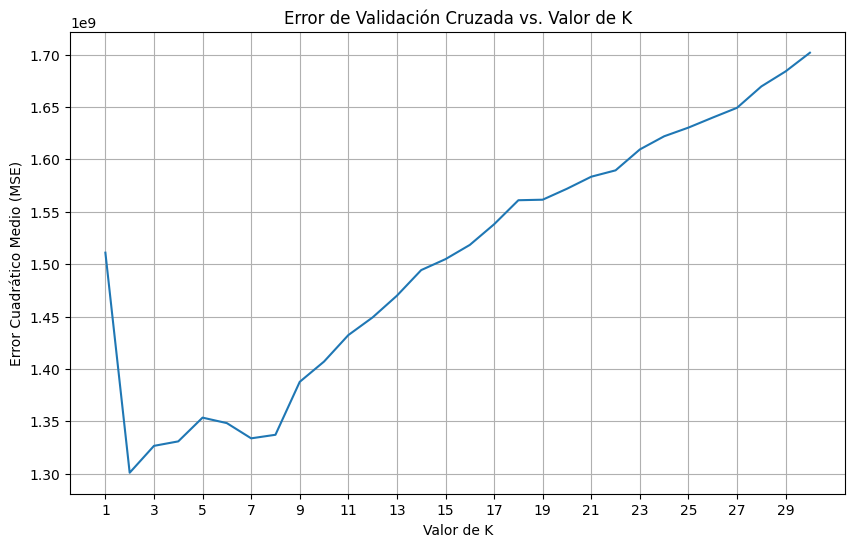

Mejor valor de k: 2


In [12]:
# Definir el modelo KNN para regresión
knn_regressor = KNeighborsRegressor()

# Configurar validación cruzada (k-fold)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Realizar validación cruzada para evaluar diferentes valores de k (número de vecinos)
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    # Usamos el negativo del error cuadrático medio como métrica
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    k_scores.append(-scores.mean())  # Convertimos a positivo para facilitar la interpretación

# Visualizar los resultados de la validación cruzada
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Error de Validación Cruzada vs. Valor de K')
plt.xticks(k_range[::2])  # Mostrar cada segundo valor en el eje X
plt.grid(True)
plt.show()

# Encontrar el mejor valor de k
best_k = k_range[np.argmin(k_scores)]
print(f"Mejor valor de k: {best_k}")

In [13]:
# Definir la cuadrícula de parámetros
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 para distancia Manhattan, p=2 para distancia Euclidiana
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_knn = grid_search.best_estimator_


Mejores parámetros encontrados:
{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


In [14]:
# Evaluación con validación cruzada
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-cv_scores)

print("Resultados de la validación cruzada (RMSE):")
for i, rmse in enumerate(rmse_cv):
    print(f"Fold {i+1}: ${int(rmse):,}")
print(f"RMSE promedio: ${int(rmse_cv.mean()):,}")
print(f"Desviación estándar: ${int(rmse_cv.std()):,}")

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_knn.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nResultados en el conjunto de prueba:")
print(f"Error cuadrático medio (MSE): ${int(mse):,}")
print(f"Raíz del error cuadrático medio (RMSE): ${int(rmse):,}")
print(f"Error absoluto medio (MAE): ${int(mae):,}")
print(f"Coeficiente de determinación (R²): {r2:.4f}")

Resultados de la validación cruzada (RMSE):
Fold 1: $30,445
Fold 2: $35,179
Fold 3: $34,596
Fold 4: $29,223
Fold 5: $34,290
RMSE promedio: $32,747
Desviación estándar: $2,426

Resultados en el conjunto de prueba:
Error cuadrático medio (MSE): $932,138,290
Raíz del error cuadrático medio (RMSE): $30,530
Error absoluto medio (MAE): $19,854
Coeficiente de determinación (R²): 0.8664


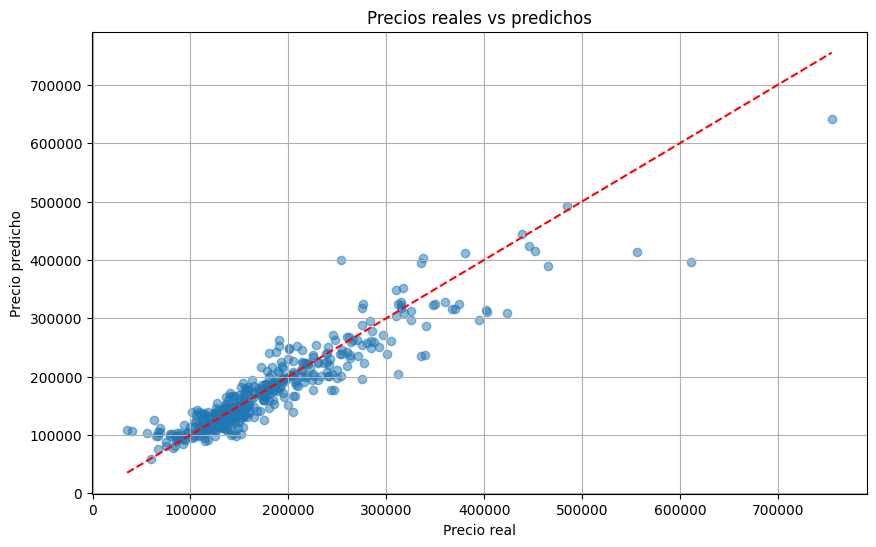

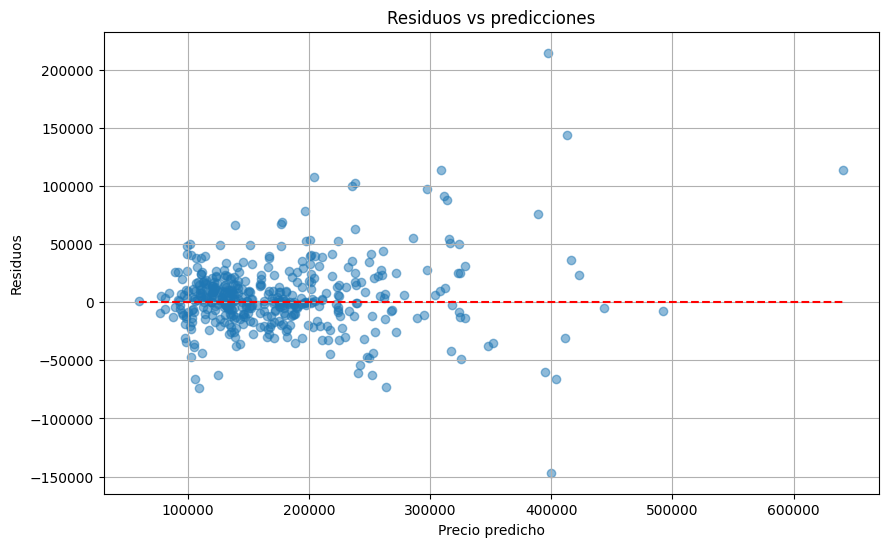

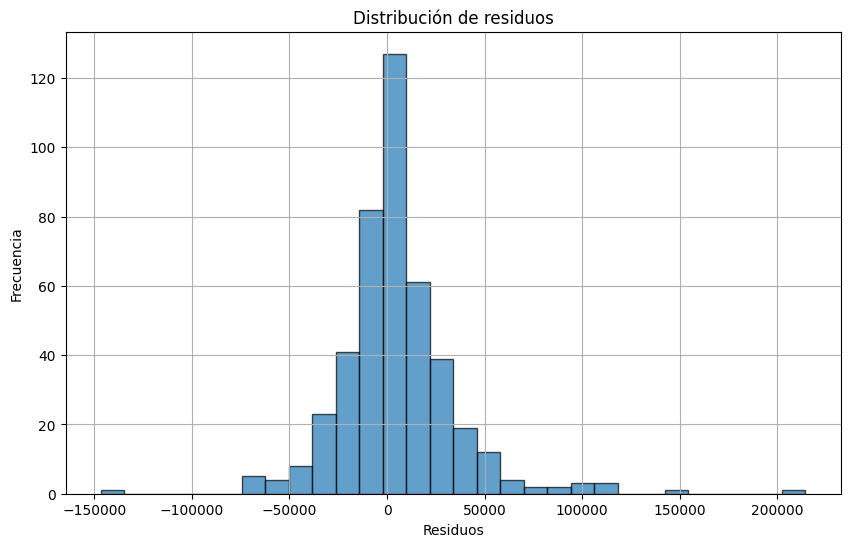

In [15]:
# Visualizar predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Precios reales vs predichos')
plt.grid(True)
plt.show()

# Visualizar los residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Precio predicho')
plt.ylabel('Residuos')
plt.title('Residuos vs predicciones')
plt.grid(True)
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Distribución de residuos')
plt.grid(True)
plt.show()

# Modelo de Clasificación con Validación Cruzada

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 1. Cargar los datos
df = pd.read_csv('../../train.csv')

# 2. Crear la variable de respuesta categórica basada en los terciles del precio de venta
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)

# Crear la categoría de precio
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económica', 'Intermedia', 'Cara']
)

print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")

# 3. Seleccionar las características para el modelo
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Codificar variables categóricas
encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    encoders[feature] = le

# 5. Estandarizar las características numéricas (importante para KNN)
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# 6. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)












# Definir la cuadrícula de parámetros
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # p=1 para distancia Manhattan, p=2 para distancia Euclidiana
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_knn = grid_search.best_estimator_

Tercil 1 (33.33%): $139,699
Tercil 2 (66.67%): $190,000
Mejores parámetros encontrados:
{'algorithm': 'auto', 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}


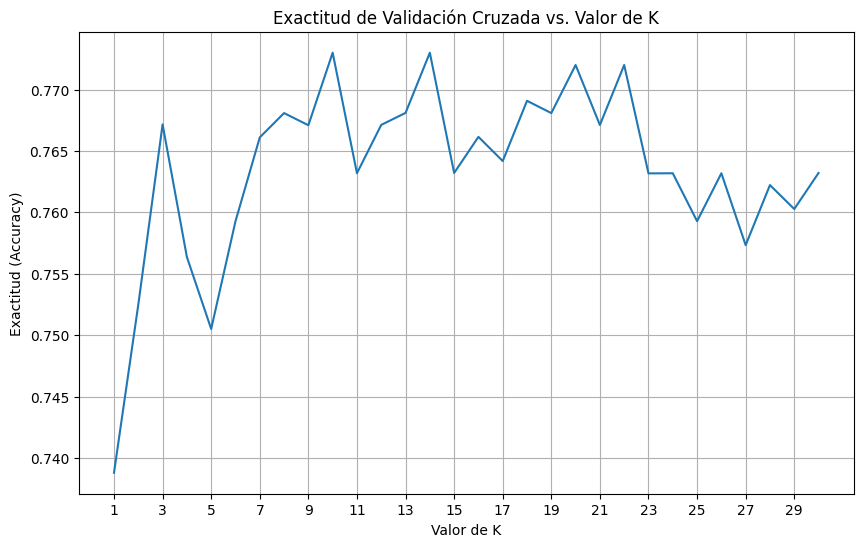

Mejor valor de k: 14


In [3]:


# Configurar validación cruzada (k-fold)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Realizar validación cruzada para evaluar diferentes valores de k (número de vecinos)
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Usamos accuracy como métrica para clasificación
    scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
    k_scores.append(scores.mean())

# Visualizar los resultados de la validación cruzada
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K')
plt.ylabel('Exactitud (Accuracy)')
plt.title('Exactitud de Validación Cruzada vs. Valor de K')
plt.xticks(k_range[::2])  # Mostrar cada segundo valor en el eje X
plt.grid(True)
plt.show()

# Encontrar el mejor valor de k
best_k = k_range[np.argmax(k_scores)]
print(f"Mejor valor de k: {best_k}")








In [4]:



# Evaluación con validación cruzada del mejor modelo
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')

print("Resultados de la validación cruzada (Exactitud):")
for i, acc in enumerate(cv_scores):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"Exactitud promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar: {cv_scores.std():.4f}")


Resultados de la validación cruzada (Exactitud):
Fold 1: 0.8151
Fold 2: 0.7911
Fold 3: 0.8082
Fold 4: 0.7911
Fold 5: 0.7842
Exactitud promedio: 0.7979
Desviación estándar: 0.0117



Matriz de Confusión:
[[125   0  20]
 [  2 123  21]
 [ 16  32  99]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        Cara       0.87      0.86      0.87       145
   Económica       0.79      0.84      0.82       146
  Intermedia       0.71      0.67      0.69       147

    accuracy                           0.79       438
   macro avg       0.79      0.79      0.79       438
weighted avg       0.79      0.79      0.79       438

Precisión del modelo optimizado: 0.7922


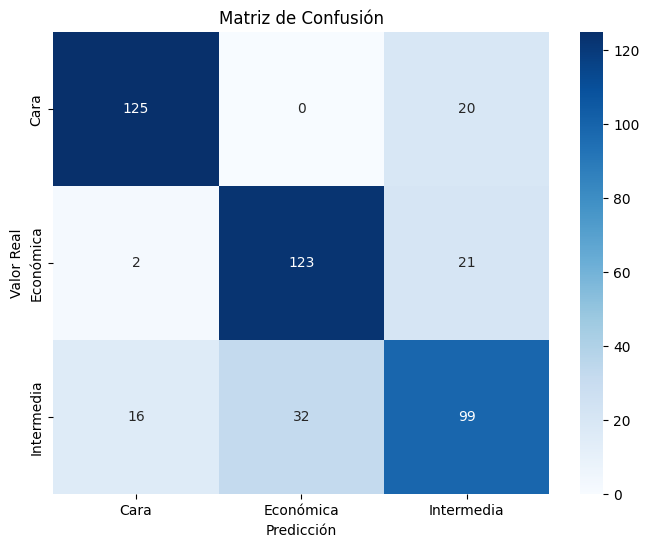

In [5]:

# Predecir en el conjunto de prueba con el mejor modelo
y_pred = best_knn.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo optimizado: {accuracy:.4f}")

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()